# About this notebook  
- PyTorch resnext50_32x4d starter code  
- StratifiedKFold 5 folds  

If this notebook is helpful, feel free to upvote :)

# Data Loading

In [1]:
import os

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./sample_submission.csv')
label_map = pd.read_json('./label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


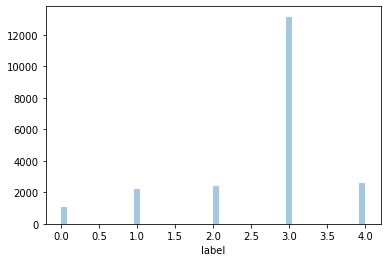

In [3]:
sns.distplot(train['label'], kde=False)

# Directory settings

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = './train_images'
TEST_PATH = './test_images'

# CFG

In [5]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    
    batch_size=16
    
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [6]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('./pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    #ConvertImageDtype
    )

from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [10]:
folds

,image_id,label,fold
0,1000015157.jpg,0,3
1,1000201771.jpg,3,2
2,100042118.jpg,1,2
3,1000723321.jpg,1,1
4,1000812911.jpg,3,2
...,...,...,...
21392,999068805.jpg,3,1
21393,999329392.jpg,3,0
21394,999474432.jpg,1,1
21395,999616605.jpg,4,2


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        if self.transform:
            #image = image.astype(np.float32)
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image.astype(np.float32)
        
        if self.transform:
            image = image.astype(np.float32)
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

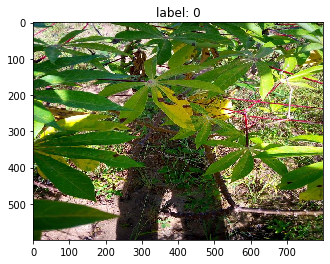

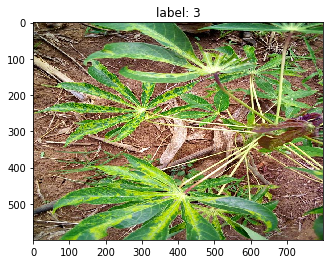

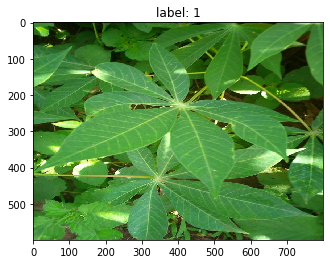

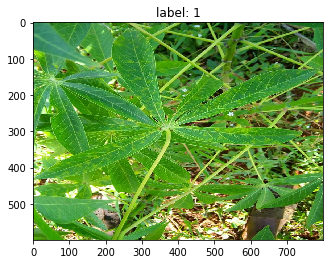

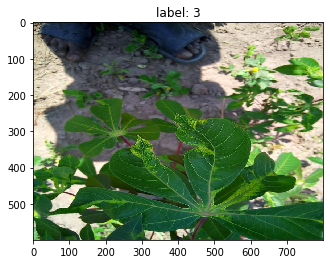

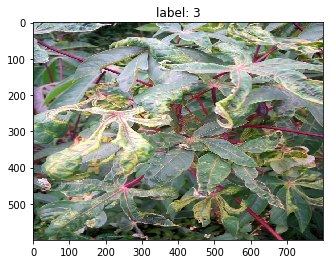

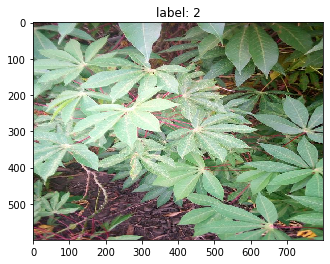

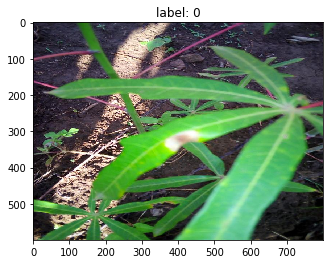

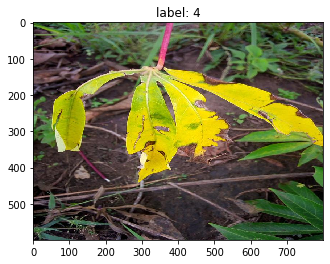

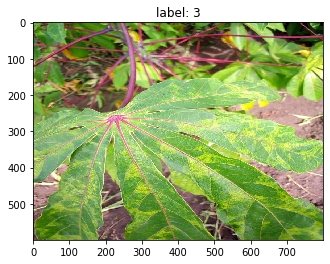

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(10):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
        RandomResizedCrop(CFG.size, CFG.size),
        #Resize(CFG.size, CFG.size),
        OneOf([RandomBrightness(limit=(0.1), p=0.5), RandomContrast(limit=(0.1), p=0.5)], p=1,),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.5,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

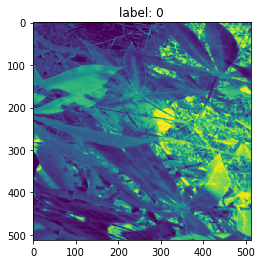

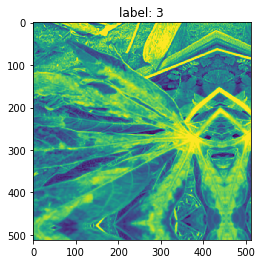

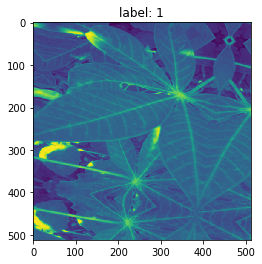

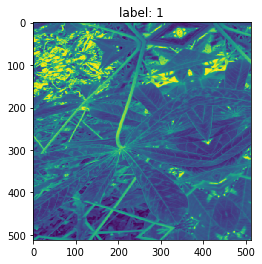

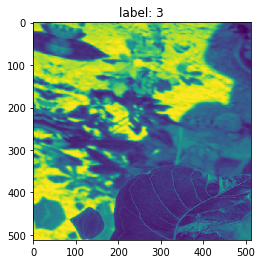

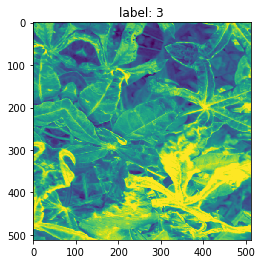

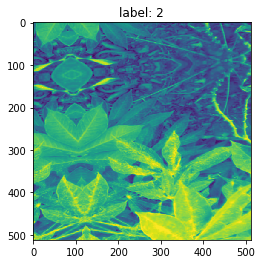

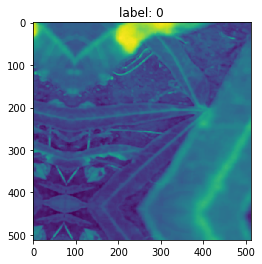

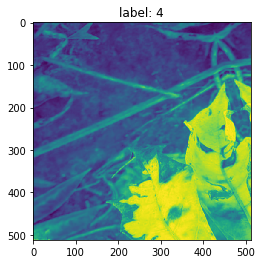

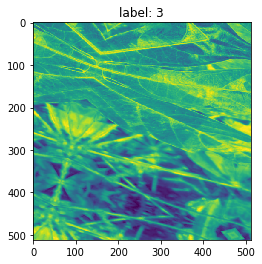

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(10):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [15]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.2080,  0.0202, -0.0412,  0.3872, -0.1043],
        [ 0.1657,  0.1141,  0.1119,  0.5569,  0.1663],
        [ 0.0199,  0.0539,  0.1195,  0.3943, -0.0546],
        [ 0.1145,  0.0446,  0.0723,  0.5219,  0.1357]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [18]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    #add_folds = folds.loc[trn_idx].reset_index(drop=True)
    #add_folds = folds[folds['label'] != 3]
    #train_folds = pd.concat([train_folds,add_folds],axis=0)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    #check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    #valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    #valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [19]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        
        for fold in range(CFG.n_fold):
        #fold = 1
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                #oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                #get_result(_oof_df)
                
        # CV result
        LOGGER.info(f"========== CV ==========")
        #get_result(oof_df)
        # save result
        #oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [20]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/1069] Data 0.727 (0.727) Elapsed 0m 2s (remain 41m 46s) Loss: 1.6146(1.6146) Grad: 13.4895  
Epoch: [1][100/1069] Data 0.000 (0.007) Elapsed 2m 26s (remain 23m 26s) Loss: 0.6262(0.8744) Grad: 6.4223  
Epoch: [1][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.6067(0.7770) Grad: 8.5879  
Epoch: [1][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 36s) Loss: 0.2704(0.7282) Grad: 3.6662  
Epoch: [1][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 10s) Loss: 0.4150(0.7062) Grad: 8.0374  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 12m 7s (remain 13m 44s) Loss: 0.3705(0.6828) Grad: 4.8299  
Epoch: [1][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.4553(0.6575) Grad: 7.3689  
Epoch: [1][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.9177(0.6425) Grad: 9.8630  
Epoch: [1][800/1069] Data 0.000 (0.001) Elapsed 19m 20s (remain 6m 28s) Loss: 0.2406(0.6305) Grad: 3.9394  
Epoch: [1][900/1069] Data 0.0

Epoch 1 - avg_train_loss: 0.6043  avg_val_loss: 0.4773  time: 1632s
Epoch 1 - Accuracy: 0.8448598130841122
Epoch 1 - Save Best Score: 0.8449 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4409(0.4773) 
Epoch: [2][0/1069] Data 0.765 (0.765) Elapsed 0m 2s (remain 39m 19s) Loss: 0.7397(0.7397) Grad: 5.6779  
Epoch: [2][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 25s) Loss: 0.6745(0.5263) Grad: 9.9979  
Epoch: [2][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.4859(0.4945) Grad: 5.5924  
Epoch: [2][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 32s) Loss: 0.2367(0.5013) Grad: 2.9835  
Epoch: [2][400/1069] Data 0.000 (0.002) Elapsed 9m 40s (remain 16m 7s) Loss: 0.5408(0.5098) Grad: 4.8801  
Epoch: [2][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 42s) Loss: 0.6246(0.4990) Grad: 6.3277  
Epoch: [2][600/1069] Data 0.000 (0.001) Elapsed 14m 30s (remain 11m 17s) Loss: 0.6829(0.4961) Grad: 5.3588  
Epoch: [2][700/1069] Data 0.000 (0.001) Elapsed 16m 54s (remain 8m 52s) Loss: 0.3768(0.4914) Grad: 5.4905  
Epoch: [2][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 2 - avg_train_loss: 0.4914  avg_val_loss: 0.4834  time: 1631s
Epoch 2 - Accuracy: 0.8352803738317757


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2886(0.4834) 
Epoch: [3][0/1069] Data 0.770 (0.770) Elapsed 0m 2s (remain 39m 38s) Loss: 0.3362(0.3362) Grad: 4.9461  
Epoch: [3][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 37s) Loss: 0.4817(0.4271) Grad: 4.5628  
Epoch: [3][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 4s) Loss: 0.2727(0.4363) Grad: 2.9532  
Epoch: [3][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 36s) Loss: 0.7188(0.4485) Grad: 4.9761  
Epoch: [3][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 10s) Loss: 0.7872(0.4524) Grad: 9.0816  
Epoch: [3][500/1069] Data 0.000 (0.002) Elapsed 12m 7s (remain 13m 44s) Loss: 0.3013(0.4644) Grad: 2.6262  
Epoch: [3][600/1069] Data 0.000 (0.001) Elapsed 14m 32s (remain 11m 19s) Loss: 0.1896(0.4613) Grad: 2.9075  
Epoch: [3][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.7501(0.4612) Grad: 6.3405  
Epoch: [3][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 3 - avg_train_loss: 0.4613  avg_val_loss: 0.4032  time: 1633s
Epoch 3 - Accuracy: 0.8630841121495327
Epoch 3 - Save Best Score: 0.8631 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4725(0.4032) 
Epoch: [4][0/1069] Data 0.817 (0.817) Elapsed 0m 2s (remain 40m 15s) Loss: 0.1844(0.1844) Grad: 2.8950  
Epoch: [4][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 28s) Loss: 0.5285(0.4453) Grad: 5.6364  
Epoch: [4][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3655(0.4368) Grad: 4.7139  
Epoch: [4][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 32s) Loss: 0.5466(0.4380) Grad: 7.0919  
Epoch: [4][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.9723(0.4411) Grad: 6.1607  
Epoch: [4][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 44s) Loss: 0.5657(0.4432) Grad: 5.6848  
Epoch: [4][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.2530(0.4424) Grad: 3.6521  
Epoch: [4][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.4067(0.4419) Grad: 3.9239  
Epoch: [4][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 4 - avg_train_loss: 0.4373  avg_val_loss: 0.3977  time: 1633s
Epoch 4 - Accuracy: 0.8724299065420561
Epoch 4 - Save Best Score: 0.8724 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3038(0.3977) 
Epoch: [5][0/1069] Data 0.763 (0.763) Elapsed 0m 2s (remain 39m 22s) Loss: 0.1317(0.1317) Grad: 2.9555  
Epoch: [5][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 31s) Loss: 0.3265(0.4019) Grad: 3.7612  
Epoch: [5][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 5s) Loss: 0.3136(0.3963) Grad: 3.6681  
Epoch: [5][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 36s) Loss: 0.2632(0.4031) Grad: 3.7044  
Epoch: [5][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 10s) Loss: 0.5727(0.4054) Grad: 6.6164  
Epoch: [5][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 44s) Loss: 0.5376(0.4143) Grad: 4.9768  
Epoch: [5][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.3024(0.4126) Grad: 2.9402  
Epoch: [5][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.7602(0.4147) Grad: 5.7423  
Epoch: [5][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 5 - avg_train_loss: 0.4082  avg_val_loss: 0.4450  time: 1633s
Epoch 5 - Accuracy: 0.8523364485981308


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3632(0.4450) 
Epoch: [6][0/1069] Data 0.840 (0.840) Elapsed 0m 2s (remain 40m 47s) Loss: 0.4906(0.4906) Grad: 6.3879  
Epoch: [6][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.3939(0.3714) Grad: 3.6965  
Epoch: [6][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 2s) Loss: 0.4378(0.3924) Grad: 3.9373  
Epoch: [6][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 37s) Loss: 0.6318(0.3962) Grad: 6.2001  
Epoch: [6][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 10s) Loss: 0.9418(0.3889) Grad: 8.3884  
Epoch: [6][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 44s) Loss: 0.2556(0.3844) Grad: 2.7864  
Epoch: [6][600/1069] Data 0.000 (0.002) Elapsed 14m 31s (remain 11m 18s) Loss: 0.4098(0.3853) Grad: 5.1714  
Epoch: [6][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.3454(0.3840) Grad: 2.9025  
Epoch: [6][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 6 - avg_train_loss: 0.3911  avg_val_loss: 0.3963  time: 1631s
Epoch 6 - Accuracy: 0.8724299065420561


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4621(0.3963) 
Epoch: [7][0/1069] Data 0.824 (0.824) Elapsed 0m 2s (remain 40m 29s) Loss: 0.5588(0.5588) Grad: 6.2387  
Epoch: [7][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 26s) Loss: 0.4667(0.3885) Grad: 5.7481  
Epoch: [7][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 57s) Loss: 0.3836(0.3742) Grad: 4.3305  
Epoch: [7][300/1069] Data 0.000 (0.003) Elapsed 7m 15s (remain 18m 31s) Loss: 0.3909(0.3824) Grad: 3.6188  
Epoch: [7][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 9s) Loss: 0.2032(0.3707) Grad: 2.6936  
Epoch: [7][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.3239(0.3643) Grad: 4.8182  
Epoch: [7][600/1069] Data 0.000 (0.001) Elapsed 14m 30s (remain 11m 18s) Loss: 0.5392(0.3613) Grad: 5.9033  
Epoch: [7][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 53s) Loss: 0.3810(0.3625) Grad: 4.3359  
Epoch: [7][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 7 - avg_train_loss: 0.3639  avg_val_loss: 0.3782  time: 1632s
Epoch 7 - Accuracy: 0.8766355140186916
Epoch 7 - Save Best Score: 0.8766 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4455(0.3782) 
Epoch: [8][0/1069] Data 0.716 (0.716) Elapsed 0m 2s (remain 38m 44s) Loss: 0.4244(0.4244) Grad: 4.9750  
Epoch: [8][100/1069] Data 0.000 (0.007) Elapsed 2m 28s (remain 23m 39s) Loss: 0.4860(0.3560) Grad: 5.9919  
Epoch: [8][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 4s) Loss: 0.1747(0.3360) Grad: 3.1328  
Epoch: [8][300/1069] Data 0.000 (0.002) Elapsed 7m 17s (remain 18m 36s) Loss: 0.4602(0.3349) Grad: 4.9609  
Epoch: [8][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.2107(0.3301) Grad: 2.9540  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 12m 7s (remain 13m 45s) Loss: 0.3871(0.3325) Grad: 5.1300  
Epoch: [8][600/1069] Data 0.000 (0.001) Elapsed 14m 32s (remain 11m 19s) Loss: 0.4166(0.3361) Grad: 4.9158  
Epoch: [8][700/1069] Data 0.000 (0.001) Elapsed 16m 57s (remain 8m 54s) Loss: 0.3387(0.3375) Grad: 3.6031  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 8 - avg_train_loss: 0.3411  avg_val_loss: 0.3761  time: 1632s
Epoch 8 - Accuracy: 0.8764018691588785


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3941(0.3761) 
Epoch: [9][0/1069] Data 0.860 (0.860) Elapsed 0m 2s (remain 41m 4s) Loss: 0.5403(0.5403) Grad: 5.5829  
Epoch: [9][100/1069] Data 0.000 (0.009) Elapsed 2m 26s (remain 23m 28s) Loss: 0.0464(0.3406) Grad: 1.0738  
Epoch: [9][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 4s) Loss: 0.1727(0.3259) Grad: 3.1577  
Epoch: [9][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 36s) Loss: 0.1850(0.3246) Grad: 3.1002  
Epoch: [9][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.2738(0.3250) Grad: 4.4194  
Epoch: [9][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.1755(0.3237) Grad: 3.7199  
Epoch: [9][600/1069] Data 0.000 (0.002) Elapsed 14m 32s (remain 11m 19s) Loss: 0.1121(0.3261) Grad: 2.3927  
Epoch: [9][700/1069] Data 0.000 (0.001) Elapsed 16m 57s (remain 8m 53s) Loss: 0.1844(0.3252) Grad: 2.2366  
Epoch: [9][800/1069] Data 0.000 (0.001) Elapsed 19m 21

Epoch 9 - avg_train_loss: 0.3219  avg_val_loss: 0.3806  time: 1632s
Epoch 9 - Accuracy: 0.875233644859813


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2841(0.3806) 
Epoch: [10][0/1069] Data 0.711 (0.711) Elapsed 0m 2s (remain 39m 2s) Loss: 0.0854(0.0854) Grad: 1.9798  
Epoch: [10][100/1069] Data 0.000 (0.007) Elapsed 2m 28s (remain 23m 39s) Loss: 0.5260(0.3071) Grad: 5.5180  
Epoch: [10][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 4s) Loss: 0.2148(0.3136) Grad: 4.9098  
Epoch: [10][300/1069] Data 0.000 (0.002) Elapsed 7m 17s (remain 18m 36s) Loss: 0.1215(0.3061) Grad: 2.3486  
Epoch: [10][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.2508(0.3106) Grad: 4.3254  
Epoch: [10][500/1069] Data 0.000 (0.002) Elapsed 12m 7s (remain 13m 45s) Loss: 0.2509(0.3133) Grad: 4.1431  
Epoch: [10][600/1069] Data 0.000 (0.001) Elapsed 14m 32s (remain 11m 19s) Loss: 0.2598(0.3120) Grad: 2.7546  
Epoch: [10][700/1069] Data 0.000 (0.001) Elapsed 16m 57s (remain 8m 54s) Loss: 0.3651(0.3164) Grad: 3.9097  
Epoch: [10][800/1069] Data 0.000 (0.001) Elaps

Epoch 10 - avg_train_loss: 0.3170  avg_val_loss: 0.3586  time: 1632s
Epoch 10 - Accuracy: 0.8829439252336448
Epoch 10 - Save Best Score: 0.8829 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3123(0.3586) 


========== fold: 0 result ==========
========== fold: 1 training ==========


Epoch: [1][0/1069] Data 0.766 (0.766) Elapsed 0m 2s (remain 39m 29s) Loss: 1.5537(1.5537) Grad: 7.1756  
Epoch: [1][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 27s) Loss: 0.4516(0.8834) Grad: 4.9688  
Epoch: [1][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.5928(0.7758) Grad: 8.8883  
Epoch: [1][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.4381(0.7340) Grad: 7.7888  
Epoch: [1][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.5314(0.7050) Grad: 6.6492  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 43s) Loss: 0.3999(0.6823) Grad: 5.9362  
Epoch: [1][600/1069] Data 0.000 (0.001) Elapsed 14m 30s (remain 11m 18s) Loss: 0.3890(0.6620) Grad: 4.1825  
Epoch: [1][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 53s) Loss: 0.5074(0.6482) Grad: 5.9750  
Epoch: [1][800/1069] Data 0.000 (0.001) Elapsed 19m 20s (remain 6m 28s) Loss: 0.7181(0.6416) Grad: 5.3848  
Epoch: [1][900/1069] Data 0.000

Epoch 1 - avg_train_loss: 0.6142  avg_val_loss: 0.4729  time: 1632s
Epoch 1 - Accuracy: 0.8467289719626169
Epoch 1 - Save Best Score: 0.8467 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2598(0.4729) 
Epoch: [2][0/1069] Data 0.748 (0.748) Elapsed 0m 2s (remain 39m 6s) Loss: 0.3897(0.3897) Grad: 6.6536  
Epoch: [2][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 1.2976(0.5383) Grad: 9.6312  
Epoch: [2][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3756(0.5066) Grad: 4.3176  
Epoch: [2][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 34s) Loss: 0.8554(0.4995) Grad: 7.8015  
Epoch: [2][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.6502(0.5039) Grad: 8.3600  
Epoch: [2][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 44s) Loss: 0.5706(0.5014) Grad: 4.9623  
Epoch: [2][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.0983(0.4912) Grad: 1.6704  
Epoch: [2][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.2960(0.4935) Grad: 4.5467  
Epoch: [2][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 2 - avg_train_loss: 0.4941  avg_val_loss: 0.4058  time: 1632s
Epoch 2 - Accuracy: 0.8656542056074766
Epoch 2 - Save Best Score: 0.8657 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0599(0.4058) 
Epoch: [3][0/1069] Data 0.720 (0.720) Elapsed 0m 2s (remain 38m 45s) Loss: 0.5098(0.5098) Grad: 4.8177  
Epoch: [3][100/1069] Data 0.000 (0.007) Elapsed 2m 26s (remain 23m 25s) Loss: 0.4645(0.4757) Grad: 4.9385  
Epoch: [3][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.6688(0.4724) Grad: 5.5644  
Epoch: [3][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 40s) Loss: 0.3520(0.4737) Grad: 3.7364  
Epoch: [3][400/1069] Data 0.000 (0.002) Elapsed 9m 44s (remain 16m 13s) Loss: 0.4849(0.4705) Grad: 4.5375  
Epoch: [3][500/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 13m 46s) Loss: 1.0093(0.4694) Grad: 6.9104  
Epoch: [3][600/1069] Data 0.000 (0.001) Elapsed 14m 33s (remain 11m 20s) Loss: 0.2225(0.4748) Grad: 3.8551  
Epoch: [3][700/1069] Data 0.000 (0.001) Elapsed 17m 0s (remain 8m 55s) Loss: 0.9963(0.4733) Grad: 6.1828  
Epoch: [3][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 3 - avg_train_loss: 0.4669  avg_val_loss: 0.3804  time: 1637s
Epoch 3 - Accuracy: 0.8782710280373832
Epoch 3 - Save Best Score: 0.8783 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0698(0.3804) 
Epoch: [4][0/1069] Data 0.712 (0.712) Elapsed 0m 2s (remain 38m 35s) Loss: 0.3204(0.3204) Grad: 3.9082  
Epoch: [4][100/1069] Data 0.000 (0.007) Elapsed 2m 26s (remain 23m 27s) Loss: 0.4389(0.4716) Grad: 4.2809  
Epoch: [4][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.4485(0.4580) Grad: 4.2113  
Epoch: [4][300/1069] Data 0.000 (0.002) Elapsed 7m 16s (remain 18m 33s) Loss: 0.6588(0.4484) Grad: 7.8580  
Epoch: [4][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.4893(0.4353) Grad: 4.2113  
Epoch: [4][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.5035(0.4385) Grad: 4.4500  
Epoch: [4][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.4648(0.4367) Grad: 6.8486  
Epoch: [4][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 53s) Loss: 0.3698(0.4368) Grad: 4.8345  
Epoch: [4][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 4 - avg_train_loss: 0.4354  avg_val_loss: 0.3449  time: 1632s
Epoch 4 - Accuracy: 0.8869158878504673
Epoch 4 - Save Best Score: 0.8869 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0383(0.3449) 
Epoch: [5][0/1069] Data 0.835 (0.835) Elapsed 0m 2s (remain 40m 42s) Loss: 0.4503(0.4503) Grad: 3.1376  
Epoch: [5][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 28s) Loss: 0.6303(0.4046) Grad: 4.8248  
Epoch: [5][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3086(0.4237) Grad: 3.8030  
Epoch: [5][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.3264(0.4329) Grad: 3.0293  
Epoch: [5][400/1069] Data 0.000 (0.002) Elapsed 9m 40s (remain 16m 7s) Loss: 0.2690(0.4303) Grad: 3.5322  
Epoch: [5][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.6769(0.4273) Grad: 7.4734  
Epoch: [5][600/1069] Data 0.000 (0.002) Elapsed 14m 31s (remain 11m 18s) Loss: 0.4128(0.4252) Grad: 3.8835  
Epoch: [5][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.3353(0.4198) Grad: 4.8562  
Epoch: [5][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 5 - avg_train_loss: 0.4155  avg_val_loss: 0.3555  time: 1631s
Epoch 5 - Accuracy: 0.8810747663551401


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0763(0.3555) 
Epoch: [6][0/1069] Data 0.746 (0.746) Elapsed 0m 2s (remain 39m 10s) Loss: 0.1308(0.1308) Grad: 1.8081  
Epoch: [6][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.3274(0.3809) Grad: 3.7868  
Epoch: [6][200/1069] Data 0.000 (0.004) Elapsed 4m 54s (remain 21m 13s) Loss: 0.2769(0.3922) Grad: 3.0233  
Epoch: [6][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 45s) Loss: 0.4898(0.3982) Grad: 3.6456  
Epoch: [6][400/1069] Data 0.000 (0.002) Elapsed 9m 48s (remain 16m 21s) Loss: 0.2279(0.3933) Grad: 4.0553  
Epoch: [6][500/1069] Data 0.000 (0.002) Elapsed 12m 15s (remain 13m 53s) Loss: 0.2705(0.3916) Grad: 4.9247  
Epoch: [6][600/1069] Data 0.000 (0.001) Elapsed 14m 42s (remain 11m 27s) Loss: 0.4391(0.3887) Grad: 4.6854  
Epoch: [6][700/1069] Data 0.000 (0.001) Elapsed 17m 9s (remain 9m 0s) Loss: 0.3016(0.3857) Grad: 4.0870  
Epoch: [6][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 6 - avg_train_loss: 0.3873  avg_val_loss: 0.3446  time: 1644s
Epoch 6 - Accuracy: 0.8873831775700934
Epoch 6 - Save Best Score: 0.8874 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0448(0.3446) 
Epoch: [7][0/1069] Data 0.772 (0.772) Elapsed 0m 2s (remain 39m 49s) Loss: 0.1655(0.1655) Grad: 2.5947  
Epoch: [7][100/1069] Data 0.000 (0.008) Elapsed 2m 29s (remain 23m 56s) Loss: 0.2704(0.3712) Grad: 5.1875  
Epoch: [7][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 18s) Loss: 0.5631(0.3615) Grad: 5.3043  
Epoch: [7][300/1069] Data 0.000 (0.003) Elapsed 7m 20s (remain 18m 44s) Loss: 0.6980(0.3645) Grad: 8.2209  
Epoch: [7][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 15s) Loss: 0.3963(0.3707) Grad: 4.0246  
Epoch: [7][500/1069] Data 0.000 (0.002) Elapsed 12m 12s (remain 13m 50s) Loss: 0.2312(0.3647) Grad: 5.0822  
Epoch: [7][600/1069] Data 0.000 (0.001) Elapsed 14m 39s (remain 11m 24s) Loss: 0.3744(0.3655) Grad: 5.2685  
Epoch: [7][700/1069] Data 0.000 (0.001) Elapsed 17m 6s (remain 8m 58s) Loss: 0.5161(0.3708) Grad: 6.1749  
Epoch: [7][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 7 - avg_train_loss: 0.3684  avg_val_loss: 0.3276  time: 1652s
Epoch 7 - Accuracy: 0.8927570093457944
Epoch 7 - Save Best Score: 0.8928 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 25s (remain 0m 0s) Loss: 0.0142(0.3276) 
Epoch: [8][0/1069] Data 0.716 (0.716) Elapsed 0m 2s (remain 39m 42s) Loss: 0.4562(0.4562) Grad: 6.9445  
Epoch: [8][100/1069] Data 0.000 (0.007) Elapsed 2m 28s (remain 23m 40s) Loss: 0.2872(0.3461) Grad: 3.5390  
Epoch: [8][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 18s) Loss: 0.3512(0.3315) Grad: 3.9510  
Epoch: [8][300/1069] Data 0.000 (0.002) Elapsed 7m 22s (remain 18m 48s) Loss: 0.1819(0.3397) Grad: 2.9784  
Epoch: [8][400/1069] Data 0.000 (0.002) Elapsed 9m 49s (remain 16m 22s) Loss: 0.4345(0.3396) Grad: 5.1579  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 12m 16s (remain 13m 54s) Loss: 0.2965(0.3471) Grad: 3.7928  
Epoch: [8][600/1069] Data 0.000 (0.001) Elapsed 14m 44s (remain 11m 28s) Loss: 0.4027(0.3485) Grad: 4.8087  
Epoch: [8][700/1069] Data 0.000 (0.001) Elapsed 17m 10s (remain 9m 1s) Loss: 0.1795(0.3491) Grad: 2.7451  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 8 - avg_train_loss: 0.3487  avg_val_loss: 0.3270  time: 1646s
Epoch 8 - Accuracy: 0.889018691588785


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0149(0.3270) 
Epoch: [9][0/1069] Data 0.819 (0.819) Elapsed 0m 2s (remain 40m 42s) Loss: 0.4199(0.4199) Grad: 4.0391  
Epoch: [9][100/1069] Data 0.000 (0.008) Elapsed 2m 30s (remain 23m 59s) Loss: 0.5864(0.3109) Grad: 5.5394  
Epoch: [9][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 20s) Loss: 0.4567(0.3153) Grad: 4.8719  
Epoch: [9][300/1069] Data 0.000 (0.003) Elapsed 7m 24s (remain 18m 54s) Loss: 0.1620(0.3185) Grad: 2.5199  
Epoch: [9][400/1069] Data 0.000 (0.002) Elapsed 9m 51s (remain 16m 25s) Loss: 0.1513(0.3203) Grad: 3.8583  
Epoch: [9][500/1069] Data 0.000 (0.002) Elapsed 12m 18s (remain 13m 57s) Loss: 0.3165(0.3230) Grad: 4.2276  
Epoch: [9][600/1069] Data 0.000 (0.001) Elapsed 14m 45s (remain 11m 29s) Loss: 0.1349(0.3242) Grad: 3.5211  
Epoch: [9][700/1069] Data 0.000 (0.001) Elapsed 17m 9s (remain 9m 0s) Loss: 0.1823(0.3246) Grad: 2.4927  
Epoch: [9][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 9 - avg_train_loss: 0.3248  avg_val_loss: 0.3319  time: 1653s
Epoch 9 - Accuracy: 0.8873831775700934


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 25s (remain 0m 0s) Loss: 0.0192(0.3319) 
Epoch: [10][0/1069] Data 0.777 (0.777) Elapsed 0m 2s (remain 40m 48s) Loss: 0.3866(0.3866) Grad: 4.5998  
Epoch: [10][100/1069] Data 0.000 (0.008) Elapsed 2m 28s (remain 23m 41s) Loss: 0.5126(0.2742) Grad: 5.2066  
Epoch: [10][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 5s) Loss: 0.1614(0.3054) Grad: 2.0223  
Epoch: [10][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 36s) Loss: 0.2923(0.3132) Grad: 5.1507  
Epoch: [10][400/1069] Data 0.000 (0.002) Elapsed 9m 42s (remain 16m 9s) Loss: 0.2104(0.3086) Grad: 2.7214  
Epoch: [10][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.1080(0.3085) Grad: 2.2150  
Epoch: [10][600/1069] Data 0.000 (0.001) Elapsed 14m 33s (remain 11m 20s) Loss: 0.1378(0.3110) Grad: 2.6002  
Epoch: [10][700/1069] Data 0.000 (0.001) Elapsed 17m 0s (remain 8m 55s) Loss: 0.3232(0.3145) Grad: 6.6667  
Epoch: [10][800/1069] Data 0.000 (0.001) Elaps

Epoch 10 - avg_train_loss: 0.3169  avg_val_loss: 0.3323  time: 1636s
Epoch 10 - Accuracy: 0.8885514018691589
========== fold: 1 result ==========
========== fold: 2 training ==========


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.0177(0.3323) 
Epoch: [1][0/1069] Data 0.792 (0.792) Elapsed 0m 2s (remain 40m 4s) Loss: 1.6223(1.6223) Grad: 11.4840  
Epoch: [1][100/1069] Data 0.000 (0.008) Elapsed 2m 29s (remain 23m 56s) Loss: 0.4825(0.8782) Grad: 5.2063  
Epoch: [1][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 21s) Loss: 0.8203(0.7557) Grad: 9.3834  
Epoch: [1][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.2785(0.7179) Grad: 5.7121  
Epoch: [1][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.6982(0.6978) Grad: 7.4249  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 12m 12s (remain 13m 51s) Loss: 0.6447(0.6686) Grad: 8.1467  
Epoch: [1][600/1069] Data 0.000 (0.001) Elapsed 14m 40s (remain 11m 25s) Loss: 0.9282(0.6519) Grad: 9.0194  
Epoch: [1][700/1069] Data 0.000 (0.001) Elapsed 17m 7s (remain 8m 59s) Loss: 0.8136(0.6404) Grad: 8.3832  
Epoch: [1][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 1 - avg_train_loss: 0.6001  avg_val_loss: 0.4990  time: 1654s
Epoch 1 - Accuracy: 0.8317363870063099
Epoch 1 - Save Best Score: 0.8317 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 25s (remain 0m 0s) Loss: 0.4027(0.4990) 
Epoch: [2][0/1069] Data 0.733 (0.733) Elapsed 0m 2s (remain 39m 51s) Loss: 0.8771(0.8771) Grad: 8.7598  
Epoch: [2][100/1069] Data 0.000 (0.007) Elapsed 2m 28s (remain 23m 45s) Loss: 1.1690(0.5081) Grad: 7.9610  
Epoch: [2][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 19s) Loss: 0.2192(0.4729) Grad: 4.7735  
Epoch: [2][300/1069] Data 0.000 (0.003) Elapsed 7m 22s (remain 18m 50s) Loss: 0.4412(0.4772) Grad: 7.0921  
Epoch: [2][400/1069] Data 0.000 (0.002) Elapsed 9m 50s (remain 16m 23s) Loss: 1.3568(0.4888) Grad: 8.2338  
Epoch: [2][500/1069] Data 0.000 (0.002) Elapsed 12m 17s (remain 13m 55s) Loss: 0.6357(0.4909) Grad: 6.0740  
Epoch: [2][600/1069] Data 0.000 (0.001) Elapsed 14m 41s (remain 11m 26s) Loss: 0.2072(0.4887) Grad: 2.7850  
Epoch: [2][700/1069] Data 0.000 (0.001) Elapsed 17m 6s (remain 8m 58s) Loss: 0.5765(0.4811) Grad: 7.4605  
Epoch: [2][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 2 - avg_train_loss: 0.4875  avg_val_loss: 0.4133  time: 1641s
Epoch 2 - Accuracy: 0.8688946015424165
Epoch 2 - Save Best Score: 0.8689 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.5544(0.4133) 
Epoch: [3][0/1069] Data 0.750 (0.750) Elapsed 0m 2s (remain 39m 16s) Loss: 0.5218(0.5218) Grad: 5.2713  
Epoch: [3][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 31s) Loss: 0.2997(0.4509) Grad: 4.6296  
Epoch: [3][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 1s) Loss: 0.9574(0.4414) Grad: 8.0946  
Epoch: [3][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 40s) Loss: 0.3818(0.4606) Grad: 2.8979  
Epoch: [3][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.2649(0.4646) Grad: 2.9277  
Epoch: [3][500/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 13m 51s) Loss: 1.4386(0.4731) Grad: 8.4552  
Epoch: [3][600/1069] Data 0.000 (0.001) Elapsed 14m 40s (remain 11m 25s) Loss: 0.1982(0.4706) Grad: 2.3227  
Epoch: [3][700/1069] Data 0.000 (0.001) Elapsed 17m 5s (remain 8m 58s) Loss: 0.4077(0.4718) Grad: 3.5507  
Epoch: [3][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 3 - avg_train_loss: 0.4664  avg_val_loss: 0.3939  time: 1648s
Epoch 3 - Accuracy: 0.8642206122925917


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0977(0.3939) 
Epoch: [4][0/1069] Data 0.840 (0.840) Elapsed 0m 2s (remain 41m 47s) Loss: 0.3926(0.3926) Grad: 3.3269  
Epoch: [4][100/1069] Data 0.000 (0.008) Elapsed 2m 29s (remain 23m 49s) Loss: 0.4676(0.4559) Grad: 4.5481  
Epoch: [4][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 19s) Loss: 0.0795(0.4385) Grad: 1.0772  
Epoch: [4][300/1069] Data 0.000 (0.003) Elapsed 7m 23s (remain 18m 51s) Loss: 0.3894(0.4402) Grad: 4.5627  
Epoch: [4][400/1069] Data 0.000 (0.002) Elapsed 9m 48s (remain 16m 20s) Loss: 0.2710(0.4509) Grad: 4.0512  
Epoch: [4][500/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 13m 51s) Loss: 0.3090(0.4395) Grad: 3.6522  
Epoch: [4][600/1069] Data 0.000 (0.002) Elapsed 14m 39s (remain 11m 24s) Loss: 0.7192(0.4417) Grad: 5.2032  
Epoch: [4][700/1069] Data 0.000 (0.001) Elapsed 17m 7s (remain 8m 59s) Loss: 0.1461(0.4429) Grad: 1.8583  
Epoch: [4][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 4 - avg_train_loss: 0.4376  avg_val_loss: 0.4274  time: 1646s
Epoch 4 - Accuracy: 0.8544052348679598


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3883(0.4274) 
Epoch: [5][0/1069] Data 0.781 (0.781) Elapsed 0m 2s (remain 39m 46s) Loss: 0.7642(0.7642) Grad: 5.4793  
Epoch: [5][100/1069] Data 0.000 (0.008) Elapsed 2m 29s (remain 23m 51s) Loss: 0.4293(0.3783) Grad: 5.5528  
Epoch: [5][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 21s) Loss: 0.2477(0.3955) Grad: 2.8161  
Epoch: [5][300/1069] Data 0.000 (0.003) Elapsed 7m 23s (remain 18m 52s) Loss: 0.0368(0.3927) Grad: 0.6004  
Epoch: [5][400/1069] Data 0.000 (0.002) Elapsed 9m 51s (remain 16m 24s) Loss: 0.4301(0.4058) Grad: 4.8918  
Epoch: [5][500/1069] Data 0.000 (0.002) Elapsed 12m 16s (remain 13m 54s) Loss: 0.1711(0.4020) Grad: 4.6770  
Epoch: [5][600/1069] Data 0.000 (0.001) Elapsed 14m 40s (remain 11m 25s) Loss: 0.1608(0.4009) Grad: 2.6390  
Epoch: [5][700/1069] Data 0.000 (0.001) Elapsed 17m 7s (remain 8m 59s) Loss: 0.2183(0.4048) Grad: 2.9120  
Epoch: [5][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 5 - avg_train_loss: 0.4042  avg_val_loss: 0.3717  time: 1651s
Epoch 5 - Accuracy: 0.8773077821921009
Epoch 5 - Save Best Score: 0.8773 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2200(0.3717) 
Epoch: [6][0/1069] Data 0.766 (0.766) Elapsed 0m 2s (remain 39m 20s) Loss: 0.6960(0.6960) Grad: 4.7868  
Epoch: [6][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 27s) Loss: 0.2888(0.4049) Grad: 3.3450  
Epoch: [6][200/1069] Data 0.000 (0.004) Elapsed 4m 53s (remain 21m 7s) Loss: 0.3612(0.3927) Grad: 3.5916  
Epoch: [6][300/1069] Data 0.000 (0.003) Elapsed 7m 20s (remain 18m 44s) Loss: 0.4349(0.3907) Grad: 3.1975  
Epoch: [6][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 15s) Loss: 0.2182(0.3901) Grad: 3.4766  
Epoch: [6][500/1069] Data 0.000 (0.002) Elapsed 12m 10s (remain 13m 47s) Loss: 0.1243(0.3821) Grad: 2.1465  
Epoch: [6][600/1069] Data 0.000 (0.001) Elapsed 14m 36s (remain 11m 22s) Loss: 0.2153(0.3839) Grad: 2.5435  
Epoch: [6][700/1069] Data 0.000 (0.001) Elapsed 17m 4s (remain 8m 57s) Loss: 0.3552(0.3874) Grad: 3.0410  
Epoch: [6][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 6 - avg_train_loss: 0.3869  avg_val_loss: 0.3738  time: 1639s
Epoch 6 - Accuracy: 0.8745033886422061


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4975(0.3738) 
Epoch: [7][0/1069] Data 0.818 (0.818) Elapsed 0m 2s (remain 40m 16s) Loss: 0.5517(0.5517) Grad: 4.1684  
Epoch: [7][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.2261(0.3491) Grad: 3.5790  
Epoch: [7][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.5495(0.3484) Grad: 5.0409  
Epoch: [7][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.5480(0.3583) Grad: 5.4154  
Epoch: [7][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.3283(0.3573) Grad: 4.5430  
Epoch: [7][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 43s) Loss: 0.1344(0.3619) Grad: 2.2881  
Epoch: [7][600/1069] Data 0.000 (0.001) Elapsed 14m 30s (remain 11m 17s) Loss: 0.1183(0.3615) Grad: 2.2625  
Epoch: [7][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 52s) Loss: 0.0884(0.3633) Grad: 1.7606  
Epoch: [7][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 7 - avg_train_loss: 0.3612  avg_val_loss: 0.3629  time: 1632s
Epoch 7 - Accuracy: 0.8824491703669082
Epoch 7 - Save Best Score: 0.8824 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 23s (remain 0m 0s) Loss: 0.3706(0.3629) 
Epoch: [8][0/1069] Data 0.786 (0.786) Elapsed 0m 2s (remain 40m 23s) Loss: 0.2192(0.2192) Grad: 3.9888  
Epoch: [8][100/1069] Data 0.000 (0.008) Elapsed 2m 30s (remain 23m 58s) Loss: 0.5815(0.3592) Grad: 6.3560  
Epoch: [8][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 14s) Loss: 0.3774(0.3808) Grad: 4.1595  
Epoch: [8][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 41s) Loss: 0.2189(0.3679) Grad: 4.0999  
Epoch: [8][400/1069] Data 0.000 (0.002) Elapsed 9m 44s (remain 16m 13s) Loss: 0.1443(0.3583) Grad: 3.7891  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 13m 46s) Loss: 0.2635(0.3565) Grad: 2.9416  
Epoch: [8][600/1069] Data 0.000 (0.001) Elapsed 14m 33s (remain 11m 20s) Loss: 0.1604(0.3545) Grad: 3.0422  
Epoch: [8][700/1069] Data 0.000 (0.001) Elapsed 16m 58s (remain 8m 54s) Loss: 0.1420(0.3448) Grad: 2.5584  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 8 - avg_train_loss: 0.3392  avg_val_loss: 0.3642  time: 1638s
Epoch 8 - Accuracy: 0.8829165692918907
Epoch 8 - Save Best Score: 0.8829 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 23s (remain 0m 0s) Loss: 0.5498(0.3642) 
Epoch: [9][0/1069] Data 0.777 (0.777) Elapsed 0m 2s (remain 39m 35s) Loss: 0.2757(0.2757) Grad: 5.5911  
Epoch: [9][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 28s) Loss: 0.1758(0.2886) Grad: 2.3017  
Epoch: [9][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.4080(0.3022) Grad: 5.7264  
Epoch: [9][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 35s) Loss: 0.2432(0.3298) Grad: 3.9506  
Epoch: [9][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 14s) Loss: 0.7083(0.3278) Grad: 7.9860  
Epoch: [9][500/1069] Data 0.000 (0.002) Elapsed 12m 11s (remain 13m 48s) Loss: 0.4432(0.3217) Grad: 8.7361  
Epoch: [9][600/1069] Data 0.000 (0.001) Elapsed 14m 39s (remain 11m 24s) Loss: 0.1025(0.3183) Grad: 2.1560  
Epoch: [9][700/1069] Data 0.000 (0.001) Elapsed 17m 5s (remain 8m 58s) Loss: 0.1250(0.3161) Grad: 3.0149  
Epoch: [9][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 9 - avg_train_loss: 0.3166  avg_val_loss: 0.3560  time: 1645s
Epoch 9 - Accuracy: 0.8889927553166628
Epoch 9 - Save Best Score: 0.8890 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 23s (remain 0m 0s) Loss: 0.4068(0.3560) 
Epoch: [10][0/1069] Data 0.816 (0.816) Elapsed 0m 2s (remain 41m 14s) Loss: 0.5780(0.5780) Grad: 5.1594  
Epoch: [10][100/1069] Data 0.000 (0.008) Elapsed 2m 30s (remain 24m 2s) Loss: 0.2146(0.3143) Grad: 4.1880  
Epoch: [10][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 15s) Loss: 0.1466(0.3107) Grad: 2.8078  
Epoch: [10][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 42s) Loss: 0.1753(0.3070) Grad: 3.8108  
Epoch: [10][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 15s) Loss: 0.1407(0.3117) Grad: 2.9775  
Epoch: [10][500/1069] Data 0.000 (0.002) Elapsed 12m 14s (remain 13m 52s) Loss: 0.3481(0.3107) Grad: 3.8828  
Epoch: [10][600/1069] Data 0.000 (0.001) Elapsed 14m 38s (remain 11m 24s) Loss: 0.0967(0.3105) Grad: 1.5573  
Epoch: [10][700/1069] Data 0.000 (0.001) Elapsed 17m 3s (remain 8m 57s) Loss: 0.0905(0.3058) Grad: 2.1594  
Epoch: [10][800/1069] Data 0.000 (0.001) Ela

Epoch 10 - avg_train_loss: 0.3080  avg_val_loss: 0.3500  time: 1643s
Epoch 10 - Accuracy: 0.8899275531666277
Epoch 10 - Save Best Score: 0.8899 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3875(0.3500) 


========== fold: 2 result ==========
========== fold: 3 training ==========


Epoch: [1][0/1069] Data 0.761 (0.761) Elapsed 0m 2s (remain 39m 19s) Loss: 1.6978(1.6978) Grad: 8.5432  
Epoch: [1][100/1069] Data 0.000 (0.008) Elapsed 2m 28s (remain 23m 38s) Loss: 0.6785(0.8701) Grad: 11.3569  
Epoch: [1][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 19s) Loss: 0.4181(0.7593) Grad: 6.7749  
Epoch: [1][300/1069] Data 0.000 (0.003) Elapsed 7m 22s (remain 18m 48s) Loss: 0.4224(0.7230) Grad: 8.7765  
Epoch: [1][400/1069] Data 0.000 (0.002) Elapsed 9m 50s (remain 16m 23s) Loss: 0.4348(0.6864) Grad: 4.7396  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 12m 16s (remain 13m 54s) Loss: 0.5513(0.6570) Grad: 8.2244  
Epoch: [1][600/1069] Data 0.000 (0.001) Elapsed 14m 44s (remain 11m 28s) Loss: 0.3771(0.6412) Grad: 4.7390  
Epoch: [1][700/1069] Data 0.000 (0.001) Elapsed 17m 10s (remain 9m 0s) Loss: 0.7948(0.6295) Grad: 7.3990  
Epoch: [1][800/1069] Data 0.000 (0.001) Elapsed 19m 38s (remain 6m 34s) Loss: 0.3664(0.6205) Grad: 6.0389  
Epoch: [1][900/1069] Data 0.0

Epoch 1 - avg_train_loss: 0.5988  avg_val_loss: 0.4708  time: 1656s
Epoch 1 - Accuracy: 0.8504323440056087
Epoch 1 - Save Best Score: 0.8504 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 23s (remain 0m 0s) Loss: 0.5697(0.4708) 
Epoch: [2][0/1069] Data 0.770 (0.770) Elapsed 0m 2s (remain 40m 7s) Loss: 0.3018(0.3018) Grad: 4.0392  
Epoch: [2][100/1069] Data 0.000 (0.008) Elapsed 2m 30s (remain 24m 0s) Loss: 0.6425(0.4907) Grad: 5.9280  
Epoch: [2][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 14s) Loss: 0.3032(0.4938) Grad: 4.0570  
Epoch: [2][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 42s) Loss: 1.1348(0.4981) Grad: 9.4983  
Epoch: [2][400/1069] Data 0.000 (0.002) Elapsed 9m 44s (remain 16m 13s) Loss: 0.5904(0.5000) Grad: 5.4814  
Epoch: [2][500/1069] Data 0.000 (0.002) Elapsed 12m 9s (remain 13m 46s) Loss: 0.4433(0.4935) Grad: 5.1179  
Epoch: [2][600/1069] Data 0.000 (0.001) Elapsed 14m 34s (remain 11m 20s) Loss: 0.4999(0.4978) Grad: 4.6275  
Epoch: [2][700/1069] Data 0.000 (0.001) Elapsed 16m 58s (remain 8m 54s) Loss: 0.3557(0.4925) Grad: 4.1679  
Epoch: [2][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 2 - avg_train_loss: 0.4924  avg_val_loss: 0.4211  time: 1634s
Epoch 2 - Accuracy: 0.8644543117550829
Epoch 2 - Save Best Score: 0.8645 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.6114(0.4211) 
Epoch: [3][0/1069] Data 0.807 (0.807) Elapsed 0m 2s (remain 40m 11s) Loss: 0.5510(0.5510) Grad: 3.4655  
Epoch: [3][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.5516(0.4651) Grad: 6.0052  
Epoch: [3][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3524(0.4771) Grad: 4.3830  
Epoch: [3][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.8361(0.4808) Grad: 6.7420  
Epoch: [3][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.2853(0.4648) Grad: 3.2884  
Epoch: [3][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.5603(0.4640) Grad: 4.4782  
Epoch: [3][600/1069] Data 0.000 (0.001) Elapsed 14m 34s (remain 11m 21s) Loss: 0.3631(0.4662) Grad: 4.4472  
Epoch: [3][700/1069] Data 0.000 (0.001) Elapsed 17m 0s (remain 8m 55s) Loss: 0.2322(0.4605) Grad: 3.1781  
Epoch: [3][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 3 - avg_train_loss: 0.4612  avg_val_loss: 0.3975  time: 1636s
Epoch 3 - Accuracy: 0.8602477214302408


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3282(0.3975) 
Epoch: [4][0/1069] Data 0.795 (0.795) Elapsed 0m 2s (remain 39m 55s) Loss: 0.4748(0.4748) Grad: 7.2341  
Epoch: [4][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 28s) Loss: 0.3090(0.4128) Grad: 2.6572  
Epoch: [4][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3342(0.4545) Grad: 5.3013  
Epoch: [4][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.7066(0.4400) Grad: 5.6630  
Epoch: [4][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.4824(0.4399) Grad: 3.9530  
Epoch: [4][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 42s) Loss: 0.9169(0.4389) Grad: 6.3215  
Epoch: [4][600/1069] Data 0.000 (0.001) Elapsed 14m 30s (remain 11m 17s) Loss: 0.5084(0.4351) Grad: 4.9855  
Epoch: [4][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 52s) Loss: 0.2638(0.4376) Grad: 3.4300  
Epoch: [4][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 4 - avg_train_loss: 0.4361  avg_val_loss: 0.3964  time: 1630s
Epoch 4 - Accuracy: 0.869362000467399
Epoch 4 - Save Best Score: 0.8694 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3818(0.3964) 
Epoch: [5][0/1069] Data 0.784 (0.784) Elapsed 0m 2s (remain 39m 46s) Loss: 0.4766(0.4766) Grad: 3.4444  
Epoch: [5][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 32s) Loss: 0.5081(0.4255) Grad: 3.1342  
Epoch: [5][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 18s) Loss: 0.9176(0.4333) Grad: 6.6142  
Epoch: [5][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.3820(0.4130) Grad: 5.4668  
Epoch: [5][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.3794(0.4042) Grad: 3.8228  
Epoch: [5][500/1069] Data 0.000 (0.002) Elapsed 12m 11s (remain 13m 48s) Loss: 0.4016(0.4029) Grad: 4.6860  
Epoch: [5][600/1069] Data 0.000 (0.001) Elapsed 14m 39s (remain 11m 24s) Loss: 0.6920(0.4018) Grad: 5.0568  
Epoch: [5][700/1069] Data 0.000 (0.001) Elapsed 17m 4s (remain 8m 57s) Loss: 0.5435(0.3980) Grad: 4.0577  
Epoch: [5][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 5 - avg_train_loss: 0.4042  avg_val_loss: 0.3980  time: 1645s
Epoch 5 - Accuracy: 0.8688946015424165


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2565(0.3980) 
Epoch: [6][0/1069] Data 0.739 (0.739) Elapsed 0m 2s (remain 39m 7s) Loss: 0.8045(0.8045) Grad: 7.4864  
Epoch: [6][100/1069] Data 0.000 (0.007) Elapsed 2m 27s (remain 23m 28s) Loss: 0.1583(0.3879) Grad: 1.8830  
Epoch: [6][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 1s) Loss: 0.3455(0.3877) Grad: 5.4001  
Epoch: [6][300/1069] Data 0.000 (0.003) Elapsed 7m 20s (remain 18m 43s) Loss: 0.8402(0.3969) Grad: 7.0220  
Epoch: [6][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 15s) Loss: 0.6056(0.4045) Grad: 5.8496  
Epoch: [6][500/1069] Data 0.000 (0.002) Elapsed 12m 10s (remain 13m 48s) Loss: 0.4550(0.3977) Grad: 4.3765  
Epoch: [6][600/1069] Data 0.000 (0.001) Elapsed 14m 35s (remain 11m 21s) Loss: 0.4985(0.3893) Grad: 5.0642  
Epoch: [6][700/1069] Data 0.000 (0.001) Elapsed 17m 3s (remain 8m 57s) Loss: 1.2722(0.3863) Grad: 7.6329  
Epoch: [6][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 6 - avg_train_loss: 0.3846  avg_val_loss: 0.3853  time: 1640s
Epoch 6 - Accuracy: 0.8707641972423463
Epoch 6 - Save Best Score: 0.8708 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4708(0.3853) 
Epoch: [7][0/1069] Data 0.736 (0.736) Elapsed 0m 2s (remain 39m 6s) Loss: 0.4005(0.4005) Grad: 5.1280  
Epoch: [7][100/1069] Data 0.000 (0.007) Elapsed 2m 27s (remain 23m 32s) Loss: 0.2030(0.4101) Grad: 1.9176  
Epoch: [7][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 17s) Loss: 0.3644(0.3649) Grad: 4.8865  
Epoch: [7][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.2305(0.3642) Grad: 4.4305  
Epoch: [7][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.0523(0.3650) Grad: 1.1199  
Epoch: [7][500/1069] Data 0.000 (0.002) Elapsed 12m 11s (remain 13m 49s) Loss: 0.2153(0.3662) Grad: 3.4649  
Epoch: [7][600/1069] Data 0.000 (0.001) Elapsed 14m 39s (remain 11m 24s) Loss: 0.3110(0.3598) Grad: 4.8029  
Epoch: [7][700/1069] Data 0.000 (0.001) Elapsed 17m 5s (remain 8m 58s) Loss: 0.1512(0.3623) Grad: 3.4094  
Epoch: [7][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 7 - avg_train_loss: 0.3525  avg_val_loss: 0.3833  time: 1651s
Epoch 7 - Accuracy: 0.8747370881046974
Epoch 7 - Save Best Score: 0.8747 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2246(0.3833) 
Epoch: [8][0/1069] Data 0.880 (0.880) Elapsed 0m 2s (remain 41m 38s) Loss: 0.1570(0.1570) Grad: 2.4577  
Epoch: [8][100/1069] Data 0.000 (0.009) Elapsed 2m 30s (remain 24m 5s) Loss: 0.3031(0.3455) Grad: 4.1354  
Epoch: [8][200/1069] Data 0.000 (0.005) Elapsed 4m 56s (remain 21m 20s) Loss: 0.5408(0.3404) Grad: 7.1872  
Epoch: [8][300/1069] Data 0.000 (0.003) Elapsed 7m 25s (remain 18m 55s) Loss: 0.3558(0.3473) Grad: 3.9261  
Epoch: [8][400/1069] Data 0.000 (0.002) Elapsed 9m 50s (remain 16m 24s) Loss: 0.6248(0.3446) Grad: 7.4741  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 12m 19s (remain 13m 58s) Loss: 0.1554(0.3372) Grad: 4.8233  
Epoch: [8][600/1069] Data 0.000 (0.002) Elapsed 14m 44s (remain 11m 29s) Loss: 0.2940(0.3325) Grad: 4.2400  
Epoch: [8][700/1069] Data 0.000 (0.001) Elapsed 17m 9s (remain 9m 0s) Loss: 0.1861(0.3345) Grad: 4.2289  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 19m 3

Epoch 8 - avg_train_loss: 0.3363  avg_val_loss: 0.3852  time: 1655s
Epoch 8 - Accuracy: 0.8794110773545221
Epoch 8 - Save Best Score: 0.8794 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 25s (remain 0m 0s) Loss: 0.3169(0.3852) 
Epoch: [9][0/1069] Data 0.736 (0.736) Elapsed 0m 2s (remain 39m 16s) Loss: 0.4105(0.4105) Grad: 6.5091  
Epoch: [9][100/1069] Data 0.000 (0.007) Elapsed 2m 27s (remain 23m 36s) Loss: 0.3655(0.3090) Grad: 4.9226  
Epoch: [9][200/1069] Data 0.000 (0.004) Elapsed 4m 56s (remain 21m 19s) Loss: 0.7095(0.3175) Grad: 7.5466  
Epoch: [9][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.4453(0.3041) Grad: 5.9115  
Epoch: [9][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.0500(0.3090) Grad: 0.9357  
Epoch: [9][500/1069] Data 0.000 (0.002) Elapsed 12m 10s (remain 13m 48s) Loss: 0.0526(0.3062) Grad: 1.0508  
Epoch: [9][600/1069] Data 0.000 (0.001) Elapsed 14m 38s (remain 11m 24s) Loss: 0.2876(0.3089) Grad: 3.1883  
Epoch: [9][700/1069] Data 0.000 (0.001) Elapsed 17m 4s (remain 8m 57s) Loss: 0.8511(0.3091) Grad: 7.4599  
Epoch: [9][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 9 - avg_train_loss: 0.3178  avg_val_loss: 0.3789  time: 1649s
Epoch 9 - Accuracy: 0.8854872633792942
Epoch 9 - Save Best Score: 0.8855 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3698(0.3789) 
Epoch: [10][0/1069] Data 0.804 (0.804) Elapsed 0m 2s (remain 40m 13s) Loss: 0.1918(0.1918) Grad: 3.8021  
Epoch: [10][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 28s) Loss: 0.2884(0.2936) Grad: 3.3608  
Epoch: [10][200/1069] Data 0.000 (0.004) Elapsed 4m 52s (remain 21m 1s) Loss: 0.3341(0.2937) Grad: 5.9388  
Epoch: [10][300/1069] Data 0.000 (0.003) Elapsed 7m 20s (remain 18m 44s) Loss: 0.0928(0.3007) Grad: 3.3285  
Epoch: [10][400/1069] Data 0.000 (0.002) Elapsed 9m 46s (remain 16m 16s) Loss: 0.2186(0.2988) Grad: 4.7624  
Epoch: [10][500/1069] Data 0.000 (0.002) Elapsed 12m 11s (remain 13m 48s) Loss: 0.1113(0.3005) Grad: 2.4763  
Epoch: [10][600/1069] Data 0.000 (0.001) Elapsed 14m 36s (remain 11m 22s) Loss: 0.2354(0.3000) Grad: 4.2100  
Epoch: [10][700/1069] Data 0.000 (0.001) Elapsed 17m 4s (remain 8m 57s) Loss: 0.3280(0.2995) Grad: 4.4866  
Epoch: [10][800/1069] Data 0.000 (0.001) Ela

Epoch 10 - avg_train_loss: 0.3071  avg_val_loss: 0.3865  time: 1641s
Epoch 10 - Accuracy: 0.8836176676793643
========== fold: 3 result ==========
========== fold: 4 training ==========


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.1992(0.3865) 
Epoch: [1][0/1069] Data 0.878 (0.878) Elapsed 0m 2s (remain 41m 27s) Loss: 1.5836(1.5836) Grad: 8.7603  
Epoch: [1][100/1069] Data 0.000 (0.009) Elapsed 2m 27s (remain 23m 29s) Loss: 0.7714(0.8694) Grad: 13.6188  
Epoch: [1][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 21m 0s) Loss: 0.8645(0.7817) Grad: 10.9234  
Epoch: [1][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 33s) Loss: 0.7269(0.7492) Grad: 8.9487  
Epoch: [1][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 7s) Loss: 0.4383(0.7025) Grad: 7.5336  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 42s) Loss: 0.5184(0.6706) Grad: 14.1614  
Epoch: [1][600/1069] Data 0.000 (0.002) Elapsed 14m 30s (remain 11m 17s) Loss: 0.5318(0.6566) Grad: 8.1637  
Epoch: [1][700/1069] Data 0.000 (0.001) Elapsed 16m 55s (remain 8m 53s) Loss: 0.4063(0.6397) Grad: 6.1477  
Epoch: [1][800/1069] Data 0.000 (0.001) Elapsed 19

Epoch 1 - avg_train_loss: 0.6061  avg_val_loss: 0.4733  time: 1641s
Epoch 1 - Accuracy: 0.842720261743398
Epoch 1 - Save Best Score: 0.8427 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2891(0.4733) 
Epoch: [2][0/1069] Data 0.768 (0.768) Elapsed 0m 2s (remain 39m 34s) Loss: 0.3587(0.3587) Grad: 3.6027  
Epoch: [2][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.3364(0.5272) Grad: 4.4343  
Epoch: [2][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 21m 0s) Loss: 0.4713(0.5319) Grad: 6.9557  
Epoch: [2][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 34s) Loss: 0.6849(0.5110) Grad: 7.0621  
Epoch: [2][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 8s) Loss: 0.7382(0.5026) Grad: 6.9022  
Epoch: [2][500/1069] Data 0.000 (0.002) Elapsed 12m 6s (remain 13m 43s) Loss: 0.5948(0.5003) Grad: 4.5971  
Epoch: [2][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.3167(0.4941) Grad: 3.8473  
Epoch: [2][700/1069] Data 0.000 (0.001) Elapsed 16m 56s (remain 8m 53s) Loss: 0.1809(0.4903) Grad: 2.9408  
Epoch: [2][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 2 - avg_train_loss: 0.4867  avg_val_loss: 0.4353  time: 1632s
Epoch 2 - Accuracy: 0.8541715354054685
Epoch 2 - Save Best Score: 0.8542 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3322(0.4353) 
Epoch: [3][0/1069] Data 0.719 (0.719) Elapsed 0m 2s (remain 38m 34s) Loss: 0.7784(0.7784) Grad: 8.3832  
Epoch: [3][100/1069] Data 0.000 (0.007) Elapsed 2m 27s (remain 23m 29s) Loss: 0.4663(0.4963) Grad: 4.6716  
Epoch: [3][200/1069] Data 0.000 (0.004) Elapsed 4m 54s (remain 21m 11s) Loss: 0.7390(0.4492) Grad: 5.4099  
Epoch: [3][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.5114(0.4461) Grad: 6.5490  
Epoch: [3][400/1069] Data 0.000 (0.002) Elapsed 9m 48s (remain 16m 20s) Loss: 0.5616(0.4609) Grad: 4.0728  
Epoch: [3][500/1069] Data 0.000 (0.002) Elapsed 12m 15s (remain 13m 54s) Loss: 0.3263(0.4628) Grad: 3.8389  
Epoch: [3][600/1069] Data 0.000 (0.001) Elapsed 14m 42s (remain 11m 27s) Loss: 0.7294(0.4540) Grad: 6.3834  
Epoch: [3][700/1069] Data 0.000 (0.001) Elapsed 17m 9s (remain 9m 0s) Loss: 0.8944(0.4543) Grad: 6.0923  
Epoch: [3][800/1069] Data 0.000 (0.001) Elapsed 19m 

Epoch 3 - avg_train_loss: 0.4565  avg_val_loss: 0.4081  time: 1653s
Epoch 3 - Accuracy: 0.8621173171301706
Epoch 3 - Save Best Score: 0.8621 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4543(0.4081) 
Epoch: [4][0/1069] Data 0.766 (0.766) Elapsed 0m 2s (remain 39m 29s) Loss: 0.1879(0.1879) Grad: 3.0725  
Epoch: [4][100/1069] Data 0.000 (0.008) Elapsed 2m 27s (remain 23m 29s) Loss: 0.4081(0.4768) Grad: 2.8820  
Epoch: [4][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 59s) Loss: 0.3823(0.4478) Grad: 2.5410  
Epoch: [4][300/1069] Data 0.000 (0.003) Elapsed 7m 19s (remain 18m 40s) Loss: 0.4233(0.4618) Grad: 4.9642  
Epoch: [4][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 15s) Loss: 0.3410(0.4523) Grad: 3.1726  
Epoch: [4][500/1069] Data 0.000 (0.002) Elapsed 12m 10s (remain 13m 48s) Loss: 0.4028(0.4474) Grad: 4.0824  
Epoch: [4][600/1069] Data 0.000 (0.001) Elapsed 14m 34s (remain 11m 21s) Loss: 0.8162(0.4484) Grad: 6.6234  
Epoch: [4][700/1069] Data 0.000 (0.001) Elapsed 17m 1s (remain 8m 56s) Loss: 1.0370(0.4511) Grad: 5.6104  
Epoch: [4][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 4 - avg_train_loss: 0.4387  avg_val_loss: 0.3963  time: 1644s
Epoch 4 - Accuracy: 0.8763729843421361
Epoch 4 - Save Best Score: 0.8764 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4472(0.3963) 
Epoch: [5][0/1069] Data 0.815 (0.815) Elapsed 0m 2s (remain 40m 8s) Loss: 0.2984(0.2984) Grad: 3.7317  
Epoch: [5][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 26s) Loss: 1.0067(0.4222) Grad: 8.4633  
Epoch: [5][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.7112(0.4347) Grad: 4.8753  
Epoch: [5][300/1069] Data 0.000 (0.003) Elapsed 7m 16s (remain 18m 32s) Loss: 0.4665(0.4267) Grad: 3.8440  
Epoch: [5][400/1069] Data 0.000 (0.002) Elapsed 9m 40s (remain 16m 7s) Loss: 0.2821(0.4250) Grad: 3.1112  
Epoch: [5][500/1069] Data 0.000 (0.002) Elapsed 12m 5s (remain 13m 42s) Loss: 0.2282(0.4164) Grad: 4.2072  
Epoch: [5][600/1069] Data 0.000 (0.001) Elapsed 14m 31s (remain 11m 18s) Loss: 0.2410(0.4219) Grad: 2.7337  
Epoch: [5][700/1069] Data 0.000 (0.001) Elapsed 16m 59s (remain 8m 55s) Loss: 0.4054(0.4203) Grad: 3.3652  
Epoch: [5][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 5 - avg_train_loss: 0.4203  avg_val_loss: 0.3686  time: 1639s
Epoch 5 - Accuracy: 0.8782425800420659
Epoch 5 - Save Best Score: 0.8782 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4737(0.3686) 
Epoch: [6][0/1069] Data 0.813 (0.813) Elapsed 0m 2s (remain 40m 27s) Loss: 0.6802(0.6802) Grad: 6.1121  
Epoch: [6][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 27s) Loss: 0.3526(0.3829) Grad: 4.3490  
Epoch: [6][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.4244(0.3882) Grad: 5.1143  
Epoch: [6][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 37s) Loss: 0.2205(0.3839) Grad: 3.1878  
Epoch: [6][400/1069] Data 0.000 (0.002) Elapsed 9m 45s (remain 16m 14s) Loss: 0.3294(0.3771) Grad: 4.5508  
Epoch: [6][500/1069] Data 0.000 (0.002) Elapsed 12m 11s (remain 13m 49s) Loss: 0.3986(0.3821) Grad: 4.1230  
Epoch: [6][600/1069] Data 0.000 (0.001) Elapsed 14m 38s (remain 11m 24s) Loss: 0.3584(0.3804) Grad: 3.7413  
Epoch: [6][700/1069] Data 0.000 (0.001) Elapsed 17m 3s (remain 8m 57s) Loss: 0.1889(0.3827) Grad: 3.0966  
Epoch: [6][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 6 - avg_train_loss: 0.3848  avg_val_loss: 0.3546  time: 1638s
Epoch 6 - Accuracy: 0.8850198644543118
Epoch 6 - Save Best Score: 0.8850 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.6546(0.3546) 
Epoch: [7][0/1069] Data 0.840 (0.840) Elapsed 0m 2s (remain 40m 41s) Loss: 0.3600(0.3600) Grad: 4.6442  
Epoch: [7][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 26s) Loss: 0.5904(0.3413) Grad: 7.4372  
Epoch: [7][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 58s) Loss: 0.0619(0.3475) Grad: 1.1286  
Epoch: [7][300/1069] Data 0.000 (0.003) Elapsed 7m 15s (remain 18m 31s) Loss: 0.1269(0.3478) Grad: 3.1921  
Epoch: [7][400/1069] Data 0.000 (0.002) Elapsed 9m 41s (remain 16m 9s) Loss: 0.3378(0.3541) Grad: 4.6638  
Epoch: [7][500/1069] Data 0.000 (0.002) Elapsed 12m 9s (remain 13m 47s) Loss: 0.4779(0.3590) Grad: 5.4053  
Epoch: [7][600/1069] Data 0.000 (0.002) Elapsed 14m 35s (remain 11m 22s) Loss: 0.4716(0.3617) Grad: 4.6474  
Epoch: [7][700/1069] Data 0.000 (0.001) Elapsed 17m 3s (remain 8m 57s) Loss: 0.2541(0.3676) Grad: 4.1842  
Epoch: [7][800/1069] Data 0.000 (0.001) Elapsed 19m 2

Epoch 7 - avg_train_loss: 0.3650  avg_val_loss: 0.3652  time: 1648s
Epoch 7 - Accuracy: 0.885253563916803
Epoch 7 - Save Best Score: 0.8853 Model


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.8950(0.3652) 
Epoch: [8][0/1069] Data 0.798 (0.798) Elapsed 0m 2s (remain 39m 55s) Loss: 0.7904(0.7904) Grad: 4.8920  
Epoch: [8][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 26s) Loss: 0.4444(0.3242) Grad: 5.1527  
Epoch: [8][200/1069] Data 0.000 (0.004) Elapsed 4m 51s (remain 20m 57s) Loss: 0.2166(0.3280) Grad: 4.3433  
Epoch: [8][300/1069] Data 0.000 (0.003) Elapsed 7m 17s (remain 18m 35s) Loss: 0.7147(0.3288) Grad: 6.4340  
Epoch: [8][400/1069] Data 0.000 (0.002) Elapsed 9m 44s (remain 16m 14s) Loss: 0.3318(0.3276) Grad: 2.9709  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 12m 9s (remain 13m 47s) Loss: 0.2214(0.3332) Grad: 4.0963  
Epoch: [8][600/1069] Data 0.000 (0.001) Elapsed 14m 33s (remain 11m 20s) Loss: 0.4655(0.3380) Grad: 4.8666  
Epoch: [8][700/1069] Data 0.000 (0.001) Elapsed 16m 58s (remain 8m 54s) Loss: 0.2093(0.3399) Grad: 2.3937  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 19m

Epoch 8 - avg_train_loss: 0.3419  avg_val_loss: 0.3521  time: 1633s
Epoch 8 - Accuracy: 0.8913297499415751
Epoch 8 - Save Best Score: 0.8913 Model


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.7553(0.3521) 
Epoch: [9][0/1069] Data 0.826 (0.826) Elapsed 0m 2s (remain 40m 39s) Loss: 0.3704(0.3704) Grad: 4.5515  
Epoch: [9][100/1069] Data 0.000 (0.008) Elapsed 2m 26s (remain 23m 27s) Loss: 0.1152(0.3226) Grad: 2.9680  
Epoch: [9][200/1069] Data 0.000 (0.004) Elapsed 4m 53s (remain 21m 6s) Loss: 0.3265(0.3156) Grad: 3.4670  
Epoch: [9][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 46s) Loss: 0.2109(0.3194) Grad: 4.8150  
Epoch: [9][400/1069] Data 0.000 (0.002) Elapsed 9m 48s (remain 16m 19s) Loss: 0.4503(0.3268) Grad: 7.4138  
Epoch: [9][500/1069] Data 0.000 (0.002) Elapsed 12m 15s (remain 13m 54s) Loss: 0.1424(0.3297) Grad: 2.4350  
Epoch: [9][600/1069] Data 0.000 (0.001) Elapsed 14m 41s (remain 11m 26s) Loss: 0.1842(0.3305) Grad: 2.8091  
Epoch: [9][700/1069] Data 0.000 (0.001) Elapsed 17m 9s (remain 9m 0s) Loss: 0.4682(0.3306) Grad: 6.2507  
Epoch: [9][800/1069] Data 0.000 (0.001) Elapsed 19m 3

Epoch 9 - avg_train_loss: 0.3279  avg_val_loss: 0.3514  time: 1648s
Epoch 9 - Accuracy: 0.8880579574666978


EVAL: [267/268] Data 0.000 (0.002) Elapsed 1m 22s (remain 0m 0s) Loss: 0.9289(0.3514) 
Epoch: [10][0/1069] Data 0.742 (0.742) Elapsed 0m 2s (remain 38m 58s) Loss: 0.2043(0.2043) Grad: 3.9159  
Epoch: [10][100/1069] Data 0.000 (0.007) Elapsed 2m 28s (remain 23m 41s) Loss: 0.2346(0.3067) Grad: 5.0697  
Epoch: [10][200/1069] Data 0.000 (0.004) Elapsed 4m 55s (remain 21m 18s) Loss: 0.3754(0.2943) Grad: 5.6835  
Epoch: [10][300/1069] Data 0.000 (0.003) Elapsed 7m 21s (remain 18m 47s) Loss: 0.2501(0.3017) Grad: 3.6894  
Epoch: [10][400/1069] Data 0.000 (0.002) Elapsed 9m 49s (remain 16m 21s) Loss: 0.4009(0.3018) Grad: 7.4777  
Epoch: [10][500/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 13m 52s) Loss: 0.3406(0.3048) Grad: 5.1348  
Epoch: [10][600/1069] Data 0.000 (0.001) Elapsed 14m 38s (remain 11m 23s) Loss: 0.4183(0.3031) Grad: 7.1095  
Epoch: [10][700/1069] Data 0.000 (0.001) Elapsed 17m 3s (remain 8m 57s) Loss: 0.0937(0.3038) Grad: 1.7954  
Epoch: [10][800/1069] Data 0.000 (0.001) El

Epoch 10 - avg_train_loss: 0.3104  avg_val_loss: 0.3524  time: 1647s
Epoch 10 - Accuracy: 0.8910960504790839
========== fold: 4 result ==========
========== CV ==========


EVAL: [267/268] Data 0.000 (0.003) Elapsed 1m 22s (remain 0m 0s) Loss: 0.9453(0.3524) 
